In [32]:
import json
import pytz
from datetime import datetime, timezone, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from transformers import pipeline
import pandas as pd
import seaborn as sns

# 1. Creating Heatmap of New ChatGPT Conversations

In [33]:
conversations_file_location = 'export_chatgpt/conversations.json' 
local_time_zone = 'Asia/Colombo' 
# pytz.all_timezones # uncomment to see a list of all supported timezones.

In [34]:
main_categories = [
    "Technology & Programming",
    "Data Science & Analytics",
    "Business & Finance",
    "Science & Research",
    "Education & Study Help",
    "Career & Professional Development",
    "Productivity & Self-Improvement",
    "General Knowledge & Facts",
    "Entertainment & Pop Culture",
    "Lifestyle & Personal Interests",
    "Philosophy & Society",
    "Current Events & News"
]

In [35]:
with open(conversations_file_location, 'r') as file:
    conversations = json.load(file)

In [36]:
def extract_info(data):
    create_times = []

    
    # Check if 'title' exists and extract 'title'
    if 'title' in data and data['title']:
        title = data['title']

    # Check if conversation 'create_time' exists in the main dictionary and extract 'create_time'
    if 'create_time' in data and data['create_time']:
        create_times.append(data['create_time'])
        

    # Check in mapping messages and extract 'create_time'
    if 'mapping' in data:
        for key, value in data['mapping'].items():
            if 'message' in value and value['message'] is not None:
                if 'create_time' in value['message'] and value['message']['create_time']:
                    create_times.append(value['message']['create_time'])

    return create_times,title

def convert_to_local_time(all_create_times):
    converted_create_times = []
    for conversation in all_create_times:
        for create_time in conversation:
            create_time_converted = datetime.fromtimestamp(create_time, tz=timezone.utc).astimezone(pytz.timezone(local_time_zone))
            converted_create_times.append(create_time_converted)
    return converted_create_times

def create_year_heatmap(convo_times, year):
    just_dates = [convo.date() for convo in convo_times if convo.year == year]
    date_counts = Counter(just_dates)

    start_date = datetime(year, 1, 1).date()
    end_date = datetime(year, 12, 31).date()
    total_days = (end_date - start_date).days + 1

    date_range = [start_date + timedelta(days=i) for i in range(total_days)]
    data = []
    for date in date_range:
        week = ((date - start_date).days + start_date.weekday()) // 7
        day_of_week = date.weekday()
        count = date_counts.get(date, 0)
        data.append((week, day_of_week, count))

    weeks_in_year = (end_date - start_date).days // 7 + 1

    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')

    if date_counts:
        max_count_date = max(date_counts, key=date_counts.get)
        max_count = date_counts[max_count_date]
    else:
        max_count_date, max_count = None, 0

    p90_count = np.percentile(list(date_counts.values()), 90) if date_counts else 1
    for week, day_of_week, count in data:
        color = plt.cm.Greens((count + 1) / p90_count) if count > 0 else 'lightgray'
        rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    month_starts = [start_date + timedelta(days=i) for i in range(total_days) if (start_date + timedelta(days=i)).day == 1]
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        plt.text(week + 0.5, 7.75, month_start.strftime('%b'), ha='center', va='center', fontsize=10, rotation=0)

    ax.set_xlim(-0.5, weeks_in_year + 0.5)
    ax.set_ylim(-0.5, 8.5)
    plt.title(
        f'{year} Message Activity Heatmap (total={sum(date_counts.values())}).\n'
        f'Most active day: {max_count_date} with {max_count} messages.',
        fontsize=16
    )
    plt.xticks([])
    plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.gca().invert_yaxis()
    plt.show()
    
def categorize_conversations(categories,conversation_titles):
    category_results = []
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli",device=0)

    for title in conversation_titles:
        result = classifier(title, categories)
        best_category = result['labels'][0]  # The category with the highest score
        category_results.append(best_category)
        
    titles_with_categories = pd.DataFrame({
    'Title': conversation_titles,
    'Best Category': category_results
    })
    
    category_counts = df['Best Category'].value_counts()
    
    # Get the counts of each category
    category_counts = df['Best Category'].value_counts().reset_index()
    category_counts.columns = ['Category', 'Count']

    # Plot the horizontal bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Category', data=category_counts, palette='Blues')

    # Add labels and title
    plt.xlabel('Conversation Count')
    plt.ylabel('Category')
    plt.title('No of Conversation under each Category')

    # Show the plot
    plt.tight_layout()
    plt.show()



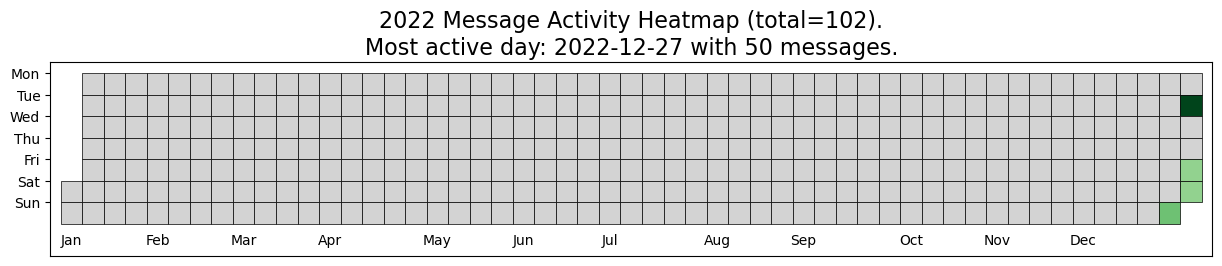

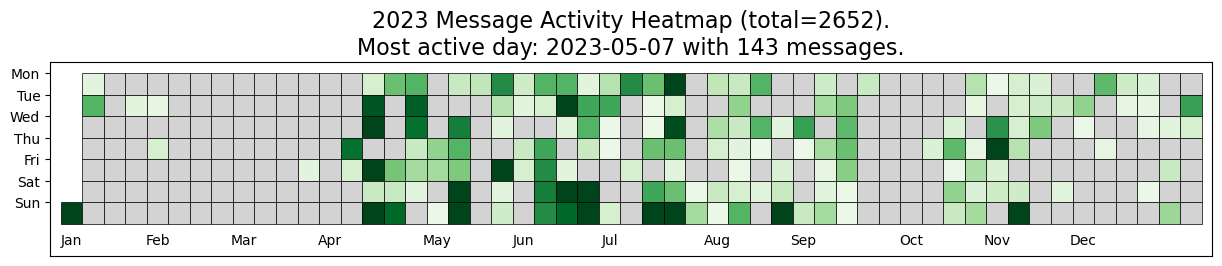

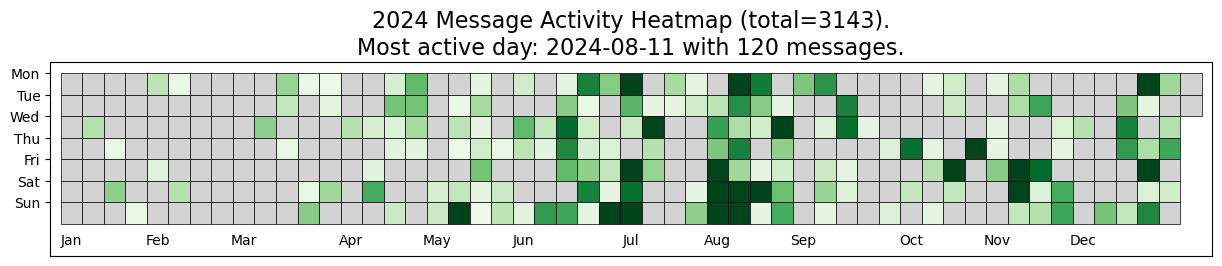

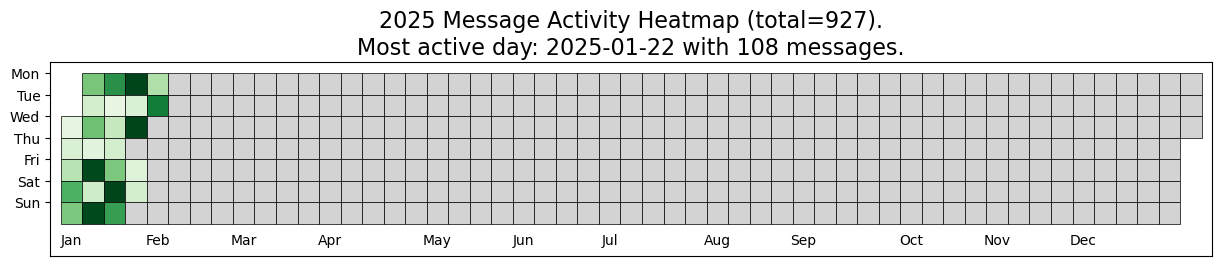

Device set to use cpu
C:\Users\hcham\AppData\Local\Temp\ipykernel_11884\748094557.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Category', data=category_counts, palette='Blues')


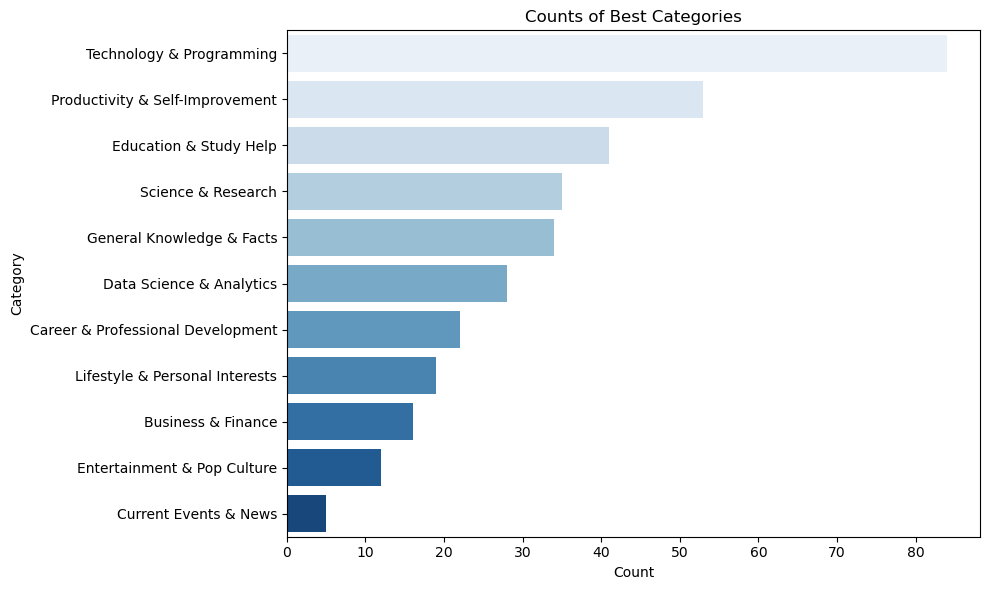

In [39]:
conversation_titles = []
all_create_times = []

for conv in conversations:
    create_times,title = extract_info(conv)
    conversation_titles.append(title)
    all_create_times.append(create_times)
    
converted_create_times = convert_to_local_time(all_create_times)

years = [2022,2023,2024,2025]

for year in years:
    create_year_heatmap(converted_create_times,year)

categorize_conversations(main_categories,conversation_titles)

C:\Users\hcham\AppData\Local\Temp\ipykernel_11884\889078734.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Category', data=category_counts, palette='Blues')


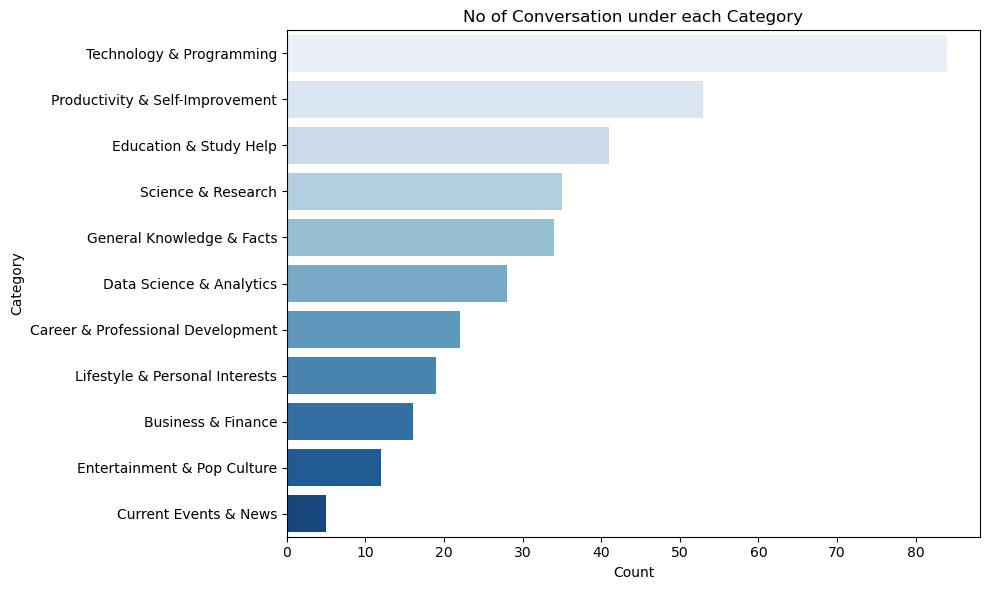

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts of each category
category_counts = df['Best Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Category', data=category_counts, palette='Blues')

# Add labels and title
plt.xlabel('Conversation Count')
plt.ylabel('Category')
plt.title('No of Conversation under each Category')

# Show the plot
plt.tight_layout()
plt.show()

